In [35]:
import os
import json
from datetime import datetime

import pandas as pd

import seaborn as sns

from os import listdir
from os.path import isfile, join, exists

TMP_DB_SQL = "/tmp/s2_ranked.sql"

logs_dir = "logs_ranked/"
logs = [f for f in listdir(logs_dir) if isfile(join(logs_dir, f))]
games = []
for log in logs:
    with open(logs_dir + "/" + log, "r") as f:
        games.append(json.load(f))

import sqlite3

if exists(TMP_DB_SQL):
    os.remove(TMP_DB_SQL)
con = sqlite3.connect(TMP_DB_SQL)
cur = con.cursor()
cur.execute('CREATE TABLE game ("id", "playlistCode", "redRoundWins", "blueRoundWins", "winner")')
cur.execute('CREATE TABLE round ("game", "round", "mapName", "startTime", "endTime", "blueCaps", "redCaps", "result");')
cur.execute(
    'CREATE TABLE event_kill ("game", "round", "timestamp", "date", "killerPlayfabId", "killerTeam", "victimPlayfabId", "victimTeam", "weaponName");')
cur.execute(
    'CREATE TABLE event_cap ("game", "round", "mapName", "timestamp", "cappingTeam", "playfabId", "millisSinceStart");')

supported_playlist_code = ["CTF-Standard-4", "CTF-Standard-6", "CTF-Standard-8"]
kills = []
for game in games:
    if game["playlistCode"] not in supported_playlist_code:
        continue
    game["redRoundWins"] = game["teamRoundWins"]["Red"]
    game["blueRoundWins"] = game["teamRoundWins"]["Blue"]
    game["winner"] = game["result"]["winner"]
    cur.execute('insert into game values (:startTime, :playlistCode, :redRoundWins, :blueRoundWins, :winner)', game)
    for round_no, round in enumerate(game["rounds"]):
        row = round
        row["round"] = round_no
        row["game"] = game["startTime"]
        caps_diff = round["redCaps"] - round["blueCaps"]
        row["result"] = "tie" if caps_diff == 0 else ("redWins" if caps_diff > 0 else "blueWins")
        cur.execute(
            'insert into round values (:game, :round, :mapName, :startTime, :endTime, :blueCaps, :redCaps, :result)',
            row)
        for event in round["events"]:
            row = dict(event)
            del row["type"]
            if event["type"] == "PLAYER_KILL":
                row["game"] = game["startTime"]
                row["round"] = round_no
                row["date"] = datetime.utcfromtimestamp(row["timestamp"] / 1000).strftime('%Y-%m-%d')
                cur.execute(
                    'insert into event_kill values (:game, :round, :timestamp, :date, :killerPlayfabId, :killerTeam, :victimPlayfabId, :victimTeam, :weaponName)',
                    row)
            elif event["type"] == "FLAG_CAP":
                row["game"] = game["startTime"]
                row["mapName"] = round["mapName"]
                row["round"] = round_no
                row["millisSinceStart"] = event["timestamp"] - round["startTime"]
                cur.execute(
                    'insert into event_cap values (:game, :round, :mapName, :timestamp, :cappingTeam, :playfabId, :millisSinceStart)',
                    row)
con.commit()

# calculate counts if kills for each date and weapon including rows with 0 values
cur.execute("""
create table weapon_kills_by_date as
    select distinct dw.date,
                    dw.weaponName,
                    sum(iif(timestamp is null, 0, 1)) kills -- count only if not null
    from
        -- all date+weapon combinations
        (select *
         from (select distinct date from event_kill)
                  cross join (select distinct weaponName from event_kill)) dw

        -- join kill events or nulls if nothing found
            left outer join event_kill ek on dw.date = ek.date and dw.weaponName = ek.weaponName

    group by dw.date, dw.weaponName
""")

skipped 128 games with other playlistCode than ['CTF-Standard-4', 'CTF-Standard-6', 'CTF-Standard-8']


## Data summary

In [33]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query,
                  con)


,first_game_start_time,last_game_start_time,games_count
0,2022-10-01 19:43:15,2023-01-07 22:20:23,1306


In [30]:
query = """
select
    playlistCode,
    count(1) games_count
from game group by playlistCode
"""
pd.read_sql_query(query,
                  con)

,playlistCode,games_count
0,CTF-Standard-4,106
1,CTF-Standard-6,1192
2,CTF-Standard-8,8


# Weapon usage trends

/tmp/ipykernel_14317/3691777645.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': '30-days rolling average of kills percentage'}, xlabel='date', ylabel='kills_percentage_rolling_average_30days'>

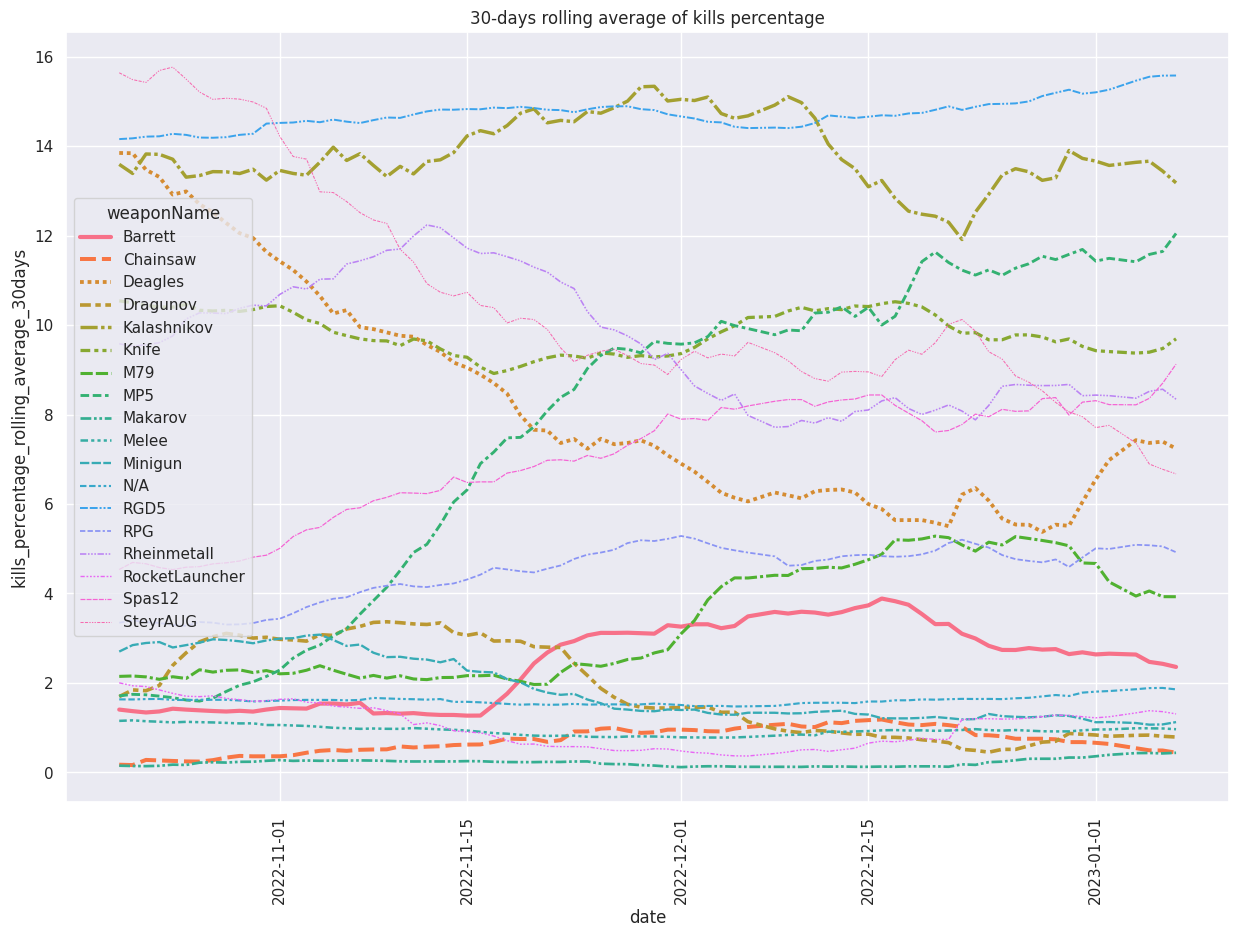

In [32]:
result9 = pd.read_sql_query("""
select
    weaponName,
    date,
    100.0 * kills / (select sum(kills) from weapon_kills_by_date wkd2 where wkd.date = wkd2.date) as kills_percentage
from weapon_kills_by_date wkd
""", con)
result9['date'] = pd.to_datetime(result9['date'])
groupby = result9.groupby("weaponName", as_index=False, group_keys=False)

result9["kills_percentage_rolling_average_14days"] = groupby.apply(
    lambda grp, freq: grp.rolling(freq, on='date', min_periods=10)['kills_percentage'].mean(), "14D")
result9["kills_percentage_rolling_average_30days"] = groupby.apply(
    lambda grp, freq: grp.rolling(freq, on='date', min_periods=20)['kills_percentage'].mean(), "30D")


def generate_rolling_average_plot(df, days):
    sns.set(rc={'figure.figsize': (15, 10)})
    plt = sns.lineplot(df, x="date", y=f"kills_percentage_rolling_average_{days}days", style="weaponName",
                       hue="weaponName", size="weaponName")
    plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
    plt.set_title(f"{days}-days rolling average of kills percentage")
    return plt


generate_rolling_average_plot(result9, 30)

/tmp/ipykernel_14317/912323586.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=90)


<AxesSubplot: title={'center': '14-days rolling average of kills percentage'}, xlabel='date', ylabel='kills_percentage_rolling_average_14days'>

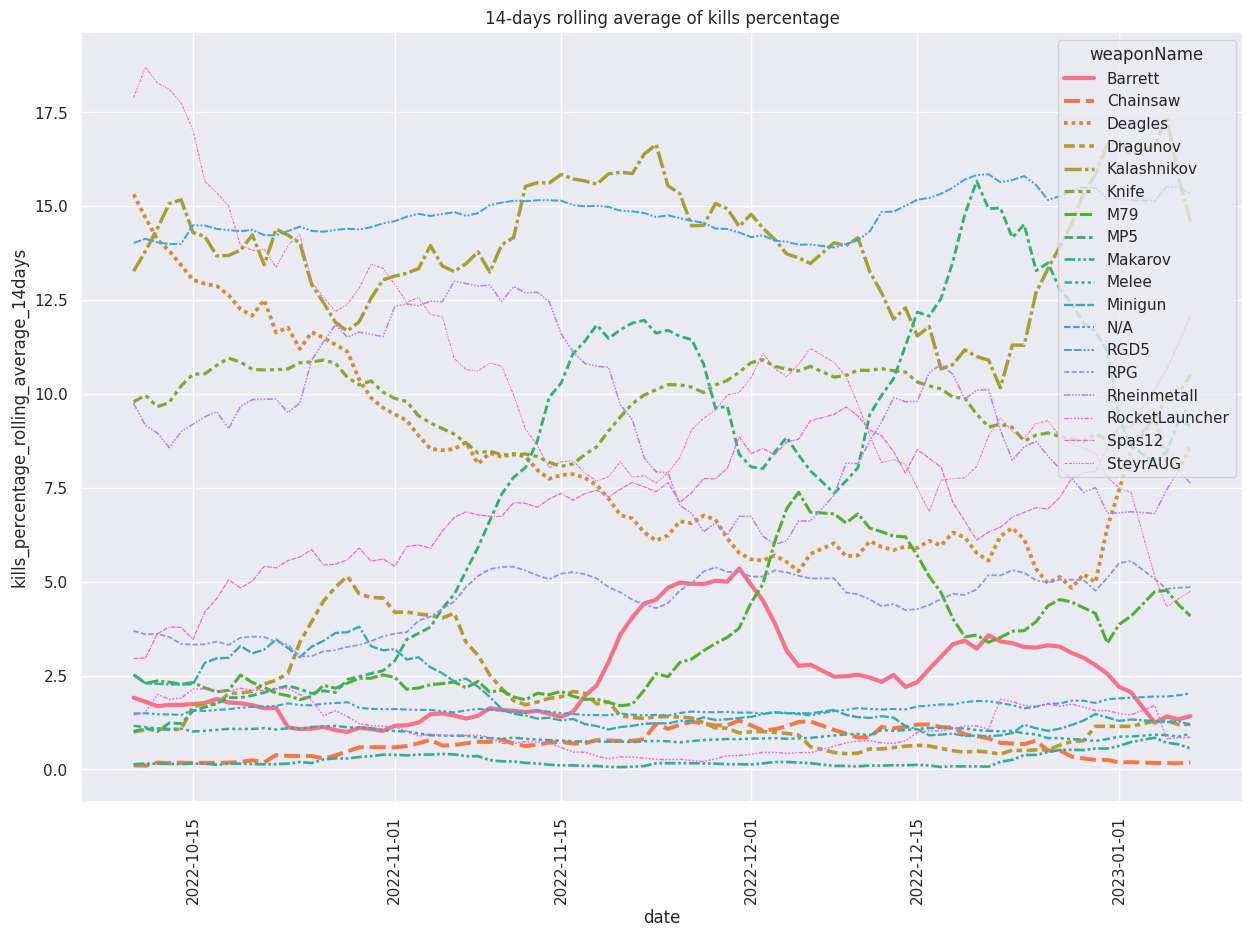

In [31]:
generate_rolling_average_plot(result9, 14)

In [28]:
result9.tail(n=300)

,weaponName,date,kills_percentage,kills_percentage_rolling_average_14days,kills_percentage_rolling_average_30days
1446,M79,2022-12-21,0.870147,3.386833,5.247018
1447,MP5,2022-12-21,5.421687,14.935904,11.397349
1448,Makarov,2022-12-21,0.000000,0.075940,0.126190
1449,Melee,2022-12-21,0.803213,1.029727,0.937011
1450,Minigun,2022-12-21,0.669344,0.887073,1.212657
...,...,...,...,...,...
1741,RPG,2023-01-07,3.482454,4.856143,4.921465
1742,Rheinmetall,2023-01-07,8.572194,7.622086,8.342480
1743,RocketLauncher,2023-01-07,0.267881,0.857124,1.306716
1744,Spas12,2023-01-07,17.546209,12.081002,9.125583
